# **Lab 3(b)**
# Convolution Neural Networks


---


Total Points: **75**

Tentative Weightage : **3%**

Submission Deadline :  **25th March 2021, 23:59 hours**

Link to the dataset : https://drive.google.com/file/d/14HjM98X9T2LIw7L5Io6kq0uRc9GFN93z/view?usp=sharing

---



General Instructions:

---



1. You have to do this lab individually
2. You may use **sklearn, seaborn, matplotlib, pandas, Tensorflow 2.x**
3. All the code should be submitted in the form of a single Jupyter notebook itself.
4. Points for each sub-section are mentioned in the appropriate question.
5. Make sure to begin early as a few experiments may consume more time to run.
6. You can use Google colab to run a jupyter notebook (https://colab.research.google.com/) How to load data in Google Colab ?(https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92) (https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/)
7. The lab must be submitted on Google classroom. The code as well as the accompanying observations should be made part of the python notebook.
8. **Code Readability** is very important. Modularize your code by making use of classes, functions that can be flexibly reused wherever necessary. Also use self explanatory variable names and add comments to describe your approach wherever necessary. You may add additional code or text blocks as necessary.
9. You are expected to submit your **inferences** (preferably in a text block) and not just an error free code.
10. Students are expected to follow the **honor code** of the class.
11. In case of any queries regarding Lab 3, please mail 2019aim1003@iitrpr.ac.in


---

### A long time ago, in a galaxy far far away....

Rey is a warrior who wants to reach her mentor, Luke Skywalker, to complete her training. No one has seen or communicated Skywalker, who has moved to someplace in outer planetary systems for ages. But Rey is fortunate enough to find a document that can help her to reach the destination. However, she is not familiar with the document's script (which happens to be Latin). Also, it is challenging to segment characters in a handwritten script. She can use her droid BB-8 for recognising words. There are two known representations for such words known to BB-8: **Alpha representation**( using alphabets) and **Omega representation**(using shapes). Since BB-8 is an astromech droid, he can use only one of them due to memory constraints.  Rey reaches out to you for help, and you (being an expert in script recognition and convolution neural networks) agree to help her. You are supposed to carry out experiments in the following section to determine which representation could help her.

*May the force be with you!!*

---

# Task: Word Recognition

You have to train a deep CNN model that can help in recognising a word, i.e. given a word-image(image with a word present in it) as input, the model yields a representation that can help in recognising the word from a set of possible words (termed as  'lexicon' of words). 

---

## Representations of the word

There are two representations for a word:

1. **Alpha representation**: This is based on the claim that a word can be represented in terms of occurences of characters in various segments of image.

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a binary vector in which each segment correspond to alphabets/characters (Shown in fig.).

![Alpha Vector](https://drive.google.com/uc?export=view&id=17rUvYXvWUc2IP8aD-O3kualSjr2dcn2b)

*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.


*For this assignment, you are supposed to use levels 2-5. 
This makes the length of final Alpha vector to be (2+3+4+5) * 26 = 364*



2. **Omega representation**: This is based on the claim that a word can be represented in terms of count of 11 primitve shapes present in various segments of image. The 11 shapes are: *ascender, descender, left small semi-circle, right small semi-circle, left large semi-circle, right large semi-circle, circle, vertical line, diagonal line, diagonal line at a slope of 135 degrees, and horizontal line*. These have been shown in figure.

![Primary Shapes](https://drive.google.com/uc?export=view&id=1573VBQwD03ae_UBjDaYk4fq84bGmDzr2)

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a vector in which each segment correspond to count of a shape.

![Omega for anagram](https://drive.google.com/uc?export=view&id=1nk1pj0yp5wunCxYeUp5ppH8hdsHF41rv)


*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.

*For this assignment, you are supposed to use levels 1-5. 
This makes the length of final Omega vector to be (1+2+3+4+5) * 11 = 165*

---

**Note**: For both representations, while splitting, in case of unequal lengths of segments, segments at the end should be of more length e.g. Level 3 split of "omega" = {o,me,ga} and "play" = {p,l,ay}. Also, for a smaller words like "ok" level 3 split = {$\epsilon$,o,k} where $\epsilon$ = empty string. 

---

Your final goal of this assignment is to detemine which representation will be more helpful for word recognition. 



In [152]:
# Import the necessary libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import random

# If using Google Colab, use the following package to display the image
# If running on your local system, cv2.imshow shall work fine
# If running on your local system please comment the line below
# from google.colab.patches import cv2_imshow

In [153]:
IMG_HEIGHT = 50
IMG_WIDTH = 250

# Dataset

The dataset used here is a synthetic word recognition dataset. It consists of images of lowercase English words, generated with handwritten-fonts. All images are single channel (grayscale) and have size 250 * 50. <br>

The dataset has the following directory structure:

<pre>
<b>WR-Dataset</b>
|__ <b>train</b>: [foo_1.png, bar_2.png, sample_3.png ....]
|__ <b>validation</b>: [foo_221.png, bar_322.png, sample_353.png ....]
|__ <b>test</b>: [bar_521.png, foo_272.png, example_433.png ....]
|__ <b>Alphabet.csv</b>
    
</pre>

Extract the paths of these directories onto different variables to facilitate accessing the dataset and thereby training the model.

In [154]:
#Add the paths for train, validation and test directories

train_dir_path="/home/anshul/Downloads/Lab3a/WR-Dataset/Train"
validation_dir_path="/home/anshul/Downloads/Lab3a/WR-Dataset/Validation"
test_dir_path="/home/anshul/Downloads/Lab3a/WR-Dataset/Test"

# Visualizing sample images

Prepare an image to label map and visualize 5 randomly chosen images from training, validation and test sets (along with their labels). Also, Mention the number of word classes present in each of the three sets.

----

**(1+1+1) points**

---

              Image    Label
0           d_5.png        d
1        here_5.png     here
2       email_0.png    email
3         was_2.png      was
4        them_4.png     them
...             ...      ...
2047   rights_4.png   rights
2048    terms_6.png    terms
2049  through_4.png  through
2050      see_1.png      see
2051     page_0.png     page

[2052 rows x 2 columns]
              Image     Label
0        help_1.png      help
1          as_6.png        as
2     message_4.png   message
3    american_5.png  american
4     address_2.png   address
..              ...       ...
395   version_4.png   version
396      just_0.png      just
397      want_1.png      want
398     total_5.png     total
399         i_1.png         i

[400 rows x 2 columns]
             Image    Label
0       over_7.png     over
1      years_4.png    years
2        all_2.png      all
3       user_2.png     user
4        off_0.png      off
..             ...      ...
103    other_4.png    other
104     home_1.png 

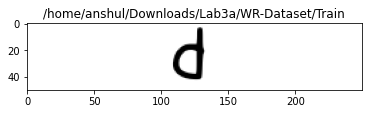

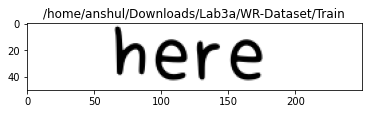

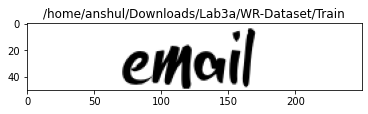

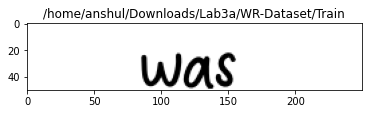

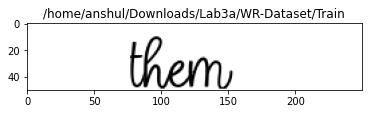

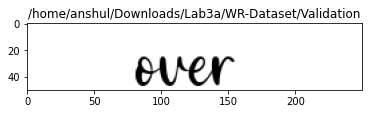

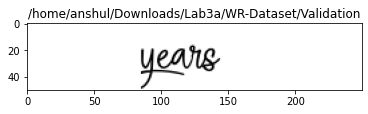

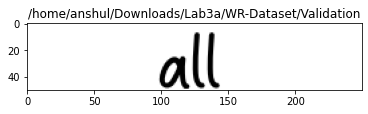

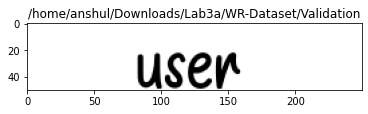

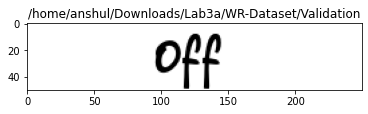

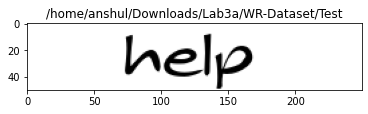

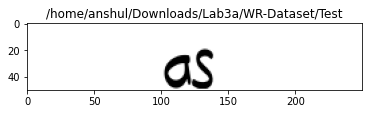

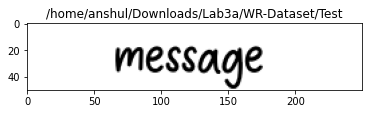

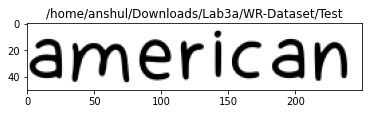

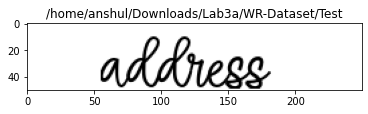

In [155]:
# Insert code to build a dataframe with Images and their corresponding labels for 3 folders (similar to Lab 3(a))
def get_dataframe(folder_name):
    
    # Insert code to give you list of all the image files in folder
    file_names=[]
    for root, dirs, files in os.walk(folder_name):
        for name in files:
            file_names.append(name)
    # Insert code to get list of labels from list of images 
    # (Hint: every image file name has its label name as prefix)
    label_names = []
    for name in file_names:
        names,_=name.split('_')
        label_names.append(names)
    # Make a dataframe with two columns - Image(file name) and Label (class label)
    df = pd.DataFrame(list(zip(file_names, label_names)), columns=['Image', 'Label'])
    # display and return the dataframe
    print(df)
    return df


# display the dataframes
train_df=get_dataframe(train_dir_path)
test_df=get_dataframe(test_dir_path)
val_df=get_dataframe(validation_dir_path)

# Visualise images from the train set
def visualize_folder(folder):
    for root, dirs, files in os.walk(folder):
        i=0
        for name in files:
                if(i==5):
                    break
                i+=1
                img=cv2.imread(os.path.join(root, name))
                plt.figure()
                plt.imshow(img)
                plt.title(folder)
        break
        
visualize_folder(train_dir_path)
# Visualise images from the validation set
visualize_folder(validation_dir_path)


# Visualise images from the test set
visualize_folder(test_dir_path)





Now, you will have to write modules that can give you vector representations for the input words.

---

**(3 + 3 points)**

---

In [156]:
df_a=pd.read_csv("/home/anshul/Downloads/Lab3a/WR-Dataset/Alphabet.csv")

In [157]:
def get_value(letter):
    alpha_np=df_a.to_numpy()
    a=['a', 0,0,1,0,0,0,1,1,0,0,0]
    fin=np.insert(alpha_np, 0, a, axis=0)
    return fin[ord(letter) - ord('a')][1:12]

In [158]:
def get_Omega_vector(word):
  #Insert the code for a function that returns Omega representation of the input word
    vector = []
    for i in range(1, 6):
        c = np.array_split(list(word[::-1]), i)[::-1]
        for j in c:
            t = [0] * 11
            for k in j:
                t = np.add(get_value(k), t)
            vector.extend(t)
  #Hint: For computing count of segments, you can add count of shapes for individual characters (already provided in Alphabet.csv file)
    return vector

In [159]:
def get_Alpha_vector(word):
  #Insert the code for a function that returns Alpha representation of the input word 
    vector = []
    for i in range(2, 6):
        c = np.array_split(list(word[::-1]), i)[::-1]
        for j in c:
            al= [0] * 26
            for k in j:
                off = ord(str(k)) - ord('a')
                al[off] = 1
            vector.extend(al)

    return vector

To test the above modules, try printing Omega and Alpha vectors for your first name.

In [160]:
name ="bhoopen"

print("Omega vector:",get_Omega_vector(name))
print("Omegavector size:", len(get_Omega_vector(name)))
print("Alphavector:",get_Alpha_vector(name))
print("Alphavector size:", len(get_Alpha_vector(name)))

Omega vector: [2, 1, 3, 0, 4, 0, 4, 5, 0, 0, 1, 2, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2, 3, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 3, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1]
Omegavector size: 165
Alphavector: [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Building Alpha model architecture 

Following is the architecture of the model that will learn Alpha representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 364 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, except the final layer use ReLu activation.

For final layer, use sigmoid activation.

**Loss function**: Binary cross-entropy

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Alpha model.

---

**(3 points)**

---

In [161]:
#Insert the code for function that returns a model which will predict Alpharepresentation

def Alpha_model(learning_rate=1e-4):
    # Instantiate Sequential model
    model = tf.keras.models.Sequential()
    
    # Add Layers
    model.add(tf.keras.layers.Conv2D(filters=64,  kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=64,  kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(4096, activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(364, activation=tf.keras.activations.sigmoid))
    # Define optimizers(Adam Optimizers), loss function and similarity metrics
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = [tf.keras.metrics.CosineSimilarity()]
    # Compile the model
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)
    
    
    # return model
    return model
    

Following is the architecture of the Omega model, i.e. model that will learn to predict Omega representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 165 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, use ReLu activation.

**Loss function**: Mean-squared error

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Omega model.

---

**(3 points)**

---

In [162]:
#Insert the code for function that returns a model which will predict Omega representation

def Omega_model(learning_rate=1e-4):
    # Instantiate Sequential model
    model = tf.keras.Sequential()
    
    # Add Layers
    model.add(tf.keras.layers.Conv2D(filters=64,  kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=64,  kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation=tf.keras.activations.relu, padding="same"))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(165, activation=tf.keras.activations.relu))
    # Define optimizers (Adam Optimizer), loss function and similarity metrics
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.MeanSquaredError()
    metrics = [tf.keras.metrics.CosineSimilarity()]    
    # Compile the model
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)
    # return model
    return model
    
    

Why did we use BCE as loss function and sigmoid as activation for final layer in Alpha model, while MSE and ReLu for Omega model? 

----

**2 points**

---





## Seen and Unseen Words

Words whose images hase been seen by the model during training are termed as seen words, while those which are part of the test set but not seen during training are called unseen words.

----

**1 point**

---

In [163]:
#Insert code to print seen word classes 
test = set(test_df['Label'])
train = set(train_df['Label'])
seen_words=list(train_df['Label'])
print("The seen words are ", seen_words)

#Insert code to print unseen word classes from test set

print("")
unseen_words=list(test-train)
print("The unseen words are ", unseen_words)

The seen words are  ['d', 'here', 'email', 'was', 'them', 'center', 'must', 'news', 'related', 'out', 'phone', 'the', 'list', 'last', 'policy', 'years', 'go', 'women', 'uk', 'please', 'based', 'subject', 'program', 'over', 'open', 'mail', 'user', 'so', 'for', 'pm', 'posted', 'can', 'case', 'both', 'may', 'site', 'this', 'links', 'also', 'on', 'uk', 'subject', 'based', 'please', 'program', 'open', 'mail', 'special', 'user', 'so', 'can', 'case', 'posted', 'pm', 'may', 'both', 'site', 'on', 'links', 'also', 'this', 'email', 'here', 'center', 'was', 'them', 'must', 'news', 'o', 'related', 'phone', 'out', 'list', 'the', 'policy', 'last', 'go', 'women', 'states', 'software', 'january', 'be', 'file', 'c', 'he', 'to', 'used', 'link', 'free', 'member', 'check', 'best', 'back', 'under', 'your', 'research', 'same', 'if', 'local', 'review', 'before', 'my', 'were', 'support', 'sign', 'back', 'your', 'under', 'if', 'local', 'into', 'review', 'my', 'before', 'find', 'were', 'support', 'r', 'sign', 's

In [164]:
NUM_EPOCHS=30
BATCH_SIZE=8

# Tuning Hyperparameters for Omega Model
We will now tune the *learning rate* for the first model. 
For that, load the train and validation data (images and their labels, i.e. Omega vectors) 

----

**1 point**

---

In [165]:
#Insert the code for loading train and validation set images and their corresponding labels 
def make_x(df, folder):
    x=[]
    for i in range(len(df)):
        img=cv2.imread(folder+'/'+df['Image'][i])
        x.append(img)
    x=np.array(x, dtype='float32')
    return x

def make_y(df):
    y=[]
    for i in range(len(df)):
        y.append(get_Omega_vector(df['Label'][i]))
    y=np.array(y)
    return y

x_train=make_x(train_df, train_dir_path)
y_train=make_y(train_df)
x_val=make_x(val_df, validation_dir_path)
y_val=make_y(val_df)

Now find the best LR for the Omega model.

----

**4 points**

---

In [166]:
def determine_Omega_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:
        
        # Insert your code here to build a model with the current learning rate
        model = Omega_model(l_rate)
        
        # Insert your code here to train the model using the training set and validate using the validation set
        h = model.fit(x=x_train,y=y_train, validation_data=(x_val, y_val), epochs=NUM_EPOCHS, batch_size = BATCH_SIZE)
        
        # Insert your code here to find the average validation accuracy for this model setting and append it to the maintained list
        avg_val_similarity.append(np.average(h.history['val_cosine_similarity']))

    # Insert your code here to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    best_val_sim = max(avg_val_similarity)
    best_LR_i=0
    for i, val_sim in enumerate(avg_val_similarity):
      if(val_sim==best_val_sim):
        best_LR_i=i
        break
    print(learning_rates[best_LR_i])
    return learning_rates[best_LR_i]

# determine_best_learning_rate() is being called here
best_Omega_lr = determine_Omega_lr()

Epoch 1/30
257/257 [==============================] - 10s 38ms/step - loss: 2031.1008 - cosine_similarity: 0.4164 - val_loss: 0.2773 - val_cosine_similarity: 0.6802
Epoch 2/30
257/257 [==============================] - 9s 37ms/step - loss: 0.3115 - cosine_similarity: 0.6655 - val_loss: 0.2491 - val_cosine_similarity: 0.7012
Epoch 3/30
257/257 [==============================] - 9s 37ms/step - loss: 0.2778 - cosine_similarity: 0.6746 - val_loss: 0.2454 - val_cosine_similarity: 0.7047
Epoch 4/30
257/257 [==============================] - 9s 37ms/step - loss: 0.2796 - cosine_similarity: 0.6856 - val_loss: 0.2407 - val_cosine_similarity: 0.7112
Epoch 5/30
257/257 [==============================] - 10s 37ms/step - loss: 0.2665 - cosine_similarity: 0.6912 - val_loss: 0.2539 - val_cosine_similarity: 0.7150
Epoch 6/30
257/257 [==============================] - 10s 38ms/step - loss: 0.2628 - cosine_similarity: 0.6905 - val_loss: 0.2447 - val_cosine_similarity: 0.7146
Epoch 7/30
257/257 [========

257/257 [==============================] - 10s 39ms/step - loss: 0.0776 - cosine_similarity: 0.9258 - val_loss: 0.0734 - val_cosine_similarity: 0.9307
Epoch 22/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0712 - cosine_similarity: 0.9332 - val_loss: 0.0698 - val_cosine_similarity: 0.9345
Epoch 23/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0631 - cosine_similarity: 0.9378 - val_loss: 0.0620 - val_cosine_similarity: 0.9407
Epoch 24/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0672 - cosine_similarity: 0.9418 - val_loss: 0.0603 - val_cosine_similarity: 0.9480
Epoch 25/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0559 - cosine_similarity: 0.9498 - val_loss: 0.0760 - val_cosine_similarity: 0.9511
Epoch 26/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0577 - cosine_similarity: 0.9503 - val_loss: 0.0652 - val_cosine_similarity: 0.9460
Epoch 27/30
257/257 [=============

In [167]:
print("Best Omega model learning rate: "+str(best_Omega_lr)) 

Best Omega model learning rate: 0.0001


# Tuning Hyperparameters for Alpha Model
We will now tune the *learning rate* for the second model. 

For that, load the train and validation data (images and their labels, i.e. Alpha vectors) 

---

**1 Point**

---

In [168]:
#Insert the code for loading train and validation set images and their corresponding labels (1 point)
def make_x_a(df, folder):
    x=[]
    for i in range(len(df)):
        img=cv2.imread(folder+'/'+df['Image'][i])
        x.append(img)
    x=np.array(x, dtype='float32')
    return x

def make_y_a(df):
    y=[]
    for i in range(len(df)):
        y.append(get_Alpha_vector(df['Label'][i]))
    y=np.array(y)
    return y

x_train_a=make_x_a(train_df, train_dir_path)
y_train_a=make_y_a(train_df)
x_val_a=make_x_a(val_df, validation_dir_path)
y_val_a=make_y_a(val_df)

Now find the best LR for the Omega model.

----

**4 points**

---

In [169]:
def determine_Alpha_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:
        
        # Insert your code here to build a model with the current learning rate
        model = Alpha_model(l_rate)
        
        # Insert your code here to train the model using the training set and validate using the validation set
        h = model.fit(x=x_train_a,y=y_train_a, validation_data=(x_val_a, y_val_a), epochs=NUM_EPOCHS, batch_size = BATCH_SIZE)
        
        # Insert your code here to find the average validation accuracy for this model setting and append it to the maintained list
        avg_val_similarity.append(np.average(h.history['val_cosine_similarity']))

    # Insert your code here to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    best_val_sim = max(avg_val_similarity)
    best_LR_i=0
    for i, val_sim in enumerate(avg_val_similarity):
      if(val_sim==best_val_sim):
        best_LR_i=i
        break
    print(learning_rates[best_LR_i])
    return learning_rates[best_LR_i]


# determine_best_learning_rate() is being called here
best_Alpha_lr = determine_Alpha_lr()

Epoch 1/30
257/257 [==============================] - 11s 39ms/step - loss: 0.2715 - cosine_similarity: 0.2721 - val_loss: 0.1663 - val_cosine_similarity: 0.2889
Epoch 2/30
257/257 [==============================] - 10s 39ms/step - loss: 0.1704 - cosine_similarity: 0.3070 - val_loss: 0.1630 - val_cosine_similarity: 0.2956
Epoch 3/30
257/257 [==============================] - 10s 39ms/step - loss: 0.1689 - cosine_similarity: 0.3136 - val_loss: 0.1584 - val_cosine_similarity: 0.2990
Epoch 4/30
257/257 [==============================] - 10s 38ms/step - loss: 0.1696 - cosine_similarity: 0.3054 - val_loss: 0.1646 - val_cosine_similarity: 0.2980
Epoch 5/30
257/257 [==============================] - 10s 38ms/step - loss: 0.1707 - cosine_similarity: 0.3091 - val_loss: 0.1640 - val_cosine_similarity: 0.2979
Epoch 6/30
257/257 [==============================] - 10s 38ms/step - loss: 0.1706 - cosine_similarity: 0.3100 - val_loss: 0.1640 - val_cosine_similarity: 0.2985
Epoch 7/30
257/257 [========

257/257 [==============================] - 10s 39ms/step - loss: 0.1081 - cosine_similarity: 0.5810 - val_loss: 0.0983 - val_cosine_similarity: 0.5953
Epoch 22/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0958 - cosine_similarity: 0.6191 - val_loss: 0.0946 - val_cosine_similarity: 0.6143
Epoch 23/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0870 - cosine_similarity: 0.6629 - val_loss: 0.0787 - val_cosine_similarity: 0.6752
Epoch 24/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0753 - cosine_similarity: 0.7016 - val_loss: 0.0689 - val_cosine_similarity: 0.7131
Epoch 25/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0631 - cosine_similarity: 0.7530 - val_loss: 0.0600 - val_cosine_similarity: 0.7505
Epoch 26/30
257/257 [==============================] - 10s 39ms/step - loss: 0.0539 - cosine_similarity: 0.7900 - val_loss: 0.0523 - val_cosine_similarity: 0.7929
Epoch 27/30
257/257 [=============

In [170]:
print("Best Aplha model learning rate: "+str(best_Alpha_lr)) 

Best Aplha model learning rate: 0.0001


---

Describe the purpose and arguments of following callbacks from `tensorflow.keras.callbacks`


1. EarlyStopping() **[2 Points]**

> It is used to monitor the progress of the model and stop the model early if the metric/quantity has stopped changing.

> Its arguments are
1)**monitor**	- the quantity to be monitored. 
2)**min_delta**	- Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
3)**patience** - The number of epochs the model will wait if there is no improvement in the monitored quantity after which the training will be stopped.
4)**mode** - can be either "auto", "max", "min". In min mode, training will stop when the quantity monitored has stopped decreasing, in "max" mode it will stop when the quantity monitored has stopped increasing and in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.

2. ReduceLROnPlateau() **[2 Points]**

> If the model stagnates after some number of epochs, then we reduce the learning rate by some factor so as to improve the convergence rate during the plateau.

> Important arguments are - 
1)**factor** - the factor by which to reduce the learning rate of the model.
2)**monitor**	- the quantity to be monitored. 
3)**min_delta**	- Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
4)**patience** - The number of epochs the model will wait if there is no improvement in the monitored quantity after which the training will be stopped.
5)**mode** - can be either "auto", "max", "min". In min mode, training will stop when the quantity monitored has stopped decreasing, in "max" mode it will stop when the quantity monitored has stopped increasing and in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
6)**min_lr** - the minimum learning rate below which we can't further reduce the learning rate.

3. CSVLogger() **[2 Points]**

> This function saves the log/history of training the model to the given location.

> Important arguments are -
1)**filename** - name of the CSV file into which to dump the logs.
2)**separator**	- String by which the seperate the elements of the log in the CSV file
3)**append** - Boolean value which tells if we should append the file to the existing CSV log file or overwrite it.

4. ModelCheckPoint()  **[2 Points]**

> It is used to create training checkpoints after some interval which store all the information about the model and the training. We can later use this to continue training where we left off, or use the saved model for predictions.

> Important arguments are -
1)**monitor**	- the quantity to be monitored. 
2)**save_freq** - The number of epochs after which to save the model periodically.
3)**mode** - can be either "auto", "max", "min". In min mode, training will stop when the quantity monitored has stopped decreasing, in "max" mode it will stop when the quantity monitored has stopped increasing and in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
4)**save_best_only** - boolean value which tells to save the best model only according to the quantity monitored. 
5)**filepath** - the path where to save the checkpoints and the model.
6)**save_weights_only** - boolean value which tells whether to save only the weights of the model, if it is false the full model is saved and if true then only the weights will be saved.

# Model building and training using callbacks

---
Now build and summarize the Omega model as per the best learning rate value determined earlier.

---

**1 Point**

---




In [171]:
# Insert code for building model using the best LR determined
omega_m = Omega_model(best_Omega_lr)

Now instantiate the four callbacks which you have described above.


---

**2 Points**

---

In [172]:
# EarlyStopping after validation loss has not improved for 5 epochs 
es_o = tf.keras.callbacks.EarlyStopping('val_loss', patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
rLRP_o = tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3)

# CSVlogger for keeping logs in filename of your choice
csvL_o = tf.keras.callbacks.CSVLogger('omega_log.csv')

# ModelCheckpoint that saves the best weights of model after every 10 epochs
mc_o = tf.keras.callbacks.ModelCheckpoint('/home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega', save_freq=10)

# Make a list of all the callbacks
callback_list_o = [es_o, rLRP_o, csvL_o, mc_o]

Now train the model using these callbacks for the loaded training word images.

---

**7 Points**

---

In [173]:
# Insert code to train with callbacks (2 points)
h = omega_m.fit(x=x_train,y = y_train, 
                          validation_data=(x_val, y_val), epochs=NUM_EPOCHS, batch_size = BATCH_SIZE, callbacks=callback_list_o)



Epoch 1/30
257/257 [==============================] - 67s 257ms/step - loss: 0.3171 - cosine_similarity: 0.6433 - val_loss: 0.2221 - val_cosine_similarity: 0.7268
Epoch 2/30
162/257 [=================>............] - ETA: 24s - loss: 0.2608 - cosine_similarity: 0.6941INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 67s 263ms/step - loss: 0.2579 - cosine_similarity: 0.6973 - val_loss: 0.2415 - val_cosine_similarity: 0.7313
Epoch 3/30
257/257 [==============================] - 66s 256ms/step - loss: 0.2491 - cosine_similarity: 0.7063 - val_loss: 0.2140 - val_cosine_similarity: 0.7316
Epoch 4/30
 58/257 [=====>........................] - ETA: 44s - loss: 0.2354 - cosine_similarity: 0.7044INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 64s 248ms/step - loss: 0.2343 - cosine_similarity: 0.7104 - val_loss: 0.2101 - val_cosine_similarity: 0.7351
Epoch 5/30
221/257 [========================>.....] - ETA: 9s - loss: 0.2341 - cosine_similarity: 0.7198INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 65s 255ms/step - loss: 0.2345 - cosine_similarity: 0.7194 - val_loss: 0.2156 - val_cosine_similarity: 0.7357
Epoch 6/30
257/257 [==============================] - 65s 255ms/step - loss: 0.2256 - cosine_similarity: 0.7229 - val_loss: 0.2030 - val_cosine_similarity: 0.7438
Epoch 7/30
117/257 [============>.................] - ETA: 33s - loss: 0.2189 - cosine_similarity: 0.7319INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 63s 247ms/step - loss: 0.2220 - cosine_similarity: 0.7318 - val_loss: 0.2125 - val_cosine_similarity: 0.7534
Epoch 8/30
257/257 [==============================] - 66s 259ms/step - loss: 0.2210 - cosine_similarity: 0.7377 - val_loss: 0.1872 - val_cosine_similarity: 0.7712
Epoch 9/30
 13/257 [>.............................] - ETA: 1:03 - loss: 0.1759 - cosine_similarity: 0.7511INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 66s 258ms/step - loss: 0.2038 - cosine_similarity: 0.7530 - val_loss: 0.1843 - val_cosine_similarity: 0.7673
Epoch 10/30
176/257 [===================>..........] - ETA: 20s - loss: 0.1894 - cosine_similarity: 0.7811INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 66s 258ms/step - loss: 0.1880 - cosine_similarity: 0.7830 - val_loss: 0.1660 - val_cosine_similarity: 0.7999
Epoch 11/30
257/257 [==============================] - 64s 250ms/step - loss: 0.1698 - cosine_similarity: 0.8108 - val_loss: 0.1515 - val_cosine_similarity: 0.8299
Epoch 12/30
 72/257 [=======>......................] - ETA: 46s - loss: 0.1559 - cosine_similarity: 0.8289INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 66s 259ms/step - loss: 0.1532 - cosine_similarity: 0.8299 - val_loss: 0.1439 - val_cosine_similarity: 0.8363
Epoch 13/30
235/257 [==========================>...] - ETA: 5s - loss: 0.1425 - cosine_similarity: 0.8429INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 66s 257ms/step - loss: 0.1424 - cosine_similarity: 0.8429 - val_loss: 0.1484 - val_cosine_similarity: 0.8477
Epoch 14/30
257/257 [==============================] - 64s 248ms/step - loss: 0.1366 - cosine_similarity: 0.8514 - val_loss: 0.1309 - val_cosine_similarity: 0.8622
Epoch 15/30
131/257 [==============>...............] - ETA: 31s - loss: 0.1307 - cosine_similarity: 0.8634INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 66s 257ms/step - loss: 0.1274 - cosine_similarity: 0.8645 - val_loss: 0.1188 - val_cosine_similarity: 0.8751
Epoch 16/30
257/257 [==============================] - 66s 258ms/step - loss: 0.1139 - cosine_similarity: 0.8777 - val_loss: 0.1142 - val_cosine_similarity: 0.8846
Epoch 17/30
 27/257 [==>...........................] - ETA: 45s - loss: 0.1067 - cosine_similarity: 0.8797INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 64s 250ms/step - loss: 0.1062 - cosine_similarity: 0.8878 - val_loss: 0.1091 - val_cosine_similarity: 0.8934
Epoch 18/30
190/257 [=====================>........] - ETA: 17s - loss: 0.1044 - cosine_similarity: 0.8952INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 67s 260ms/step - loss: 0.1046 - cosine_similarity: 0.8956 - val_loss: 0.0968 - val_cosine_similarity: 0.9037
Epoch 19/30
257/257 [==============================] - 66s 260ms/step - loss: 0.0931 - cosine_similarity: 0.9064 - val_loss: 0.0938 - val_cosine_similarity: 0.9057
Epoch 20/30
 86/257 [=========>....................] - ETA: 40s - loss: 0.0852 - cosine_similarity: 0.9132INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 66s 259ms/step - loss: 0.0867 - cosine_similarity: 0.9150 - val_loss: 0.0876 - val_cosine_similarity: 0.9187
Epoch 21/30
249/257 [============================>.] - ETA: 1s - loss: 0.0826 - cosine_similarity: 0.9227INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 64s 249ms/step - loss: 0.0826 - cosine_similarity: 0.9227 - val_loss: 0.0734 - val_cosine_similarity: 0.9290
Epoch 22/30
257/257 [==============================] - 65s 256ms/step - loss: 0.0724 - cosine_similarity: 0.9309 - val_loss: 0.1091 - val_cosine_similarity: 0.9258
Epoch 23/30
145/257 [===============>..............] - ETA: 27s - loss: 0.0727 - cosine_similarity: 0.9322INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 65s 255ms/step - loss: 0.0708 - cosine_similarity: 0.9336 - val_loss: 0.0721 - val_cosine_similarity: 0.9406
Epoch 24/30
257/257 [==============================] - 64s 248ms/step - loss: 0.0614 - cosine_similarity: 0.9419 - val_loss: 0.0601 - val_cosine_similarity: 0.9441
Epoch 25/30
 41/257 [===>..........................] - ETA: 54s - loss: 0.0593 - cosine_similarity: 0.9433INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 66s 258ms/step - loss: 0.0577 - cosine_similarity: 0.9450 - val_loss: 0.0547 - val_cosine_similarity: 0.9510
Epoch 26/30
204/257 [======================>.......] - ETA: 13s - loss: 0.0550 - cosine_similarity: 0.9504INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 65s 252ms/step - loss: 0.0554 - cosine_similarity: 0.9503 - val_loss: 0.0474 - val_cosine_similarity: 0.9542
Epoch 27/30
257/257 [==============================] - 63s 247ms/step - loss: 0.0628 - cosine_similarity: 0.9485 - val_loss: 0.0439 - val_cosine_similarity: 0.9578
Epoch 28/30
100/257 [==========>...................] - ETA: 39s - loss: 0.0509 - cosine_similarity: 0.9572INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega/assets


257/257 [==============================] - 66s 257ms/step - loss: 0.0491 - cosine_similarity: 0.9575 - val_loss: 0.0448 - val_cosine_similarity: 0.9603
Epoch 29/30
257/257 [==============================] - 65s 255ms/step - loss: 0.0414 - cosine_similarity: 0.9617 - val_loss: 0.0422 - val_cosine_similarity: 0.9651


Epoch 30/30
257/257 [==============================] - 66s 259ms/step - loss: 0.0419 - cosine_similarity: 0.9632 - val_loss: 0.0394 - val_cosine_similarity: 0.9673


In [174]:
# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)
df=pd.read_csv("/home/anshul/Downloads/Lab3a/omega_log.csv")
training_acc=df['cosine_similarity'].values.tolist()
validation_acc=df['val_cosine_similarity'].values.tolist()
training_loss=df['loss'].values.tolist()
validation_loss=df['val_loss'].values.tolist()
epochs_list=df['epoch'].values.tolist()

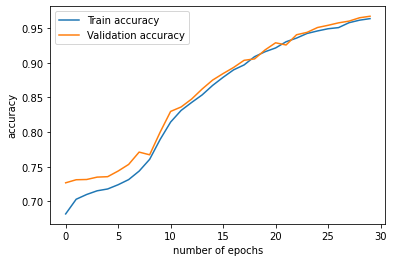

In [175]:
# Insert your code here to plot Epochs Vs. training and validation accuracy (2 points)
plt.plot(epochs_list, training_acc)
plt.plot(epochs_list, validation_acc)
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend(["Train accuracy", "Validation accuracy"])

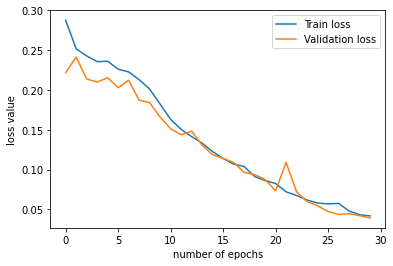

In [176]:
# Insert your code here to plot Epochs Vs. training and validation loss (2 points)
plt.plot(epochs_list, training_loss)
plt.plot(epochs_list, validation_loss)
plt.xlabel("number of epochs")
plt.ylabel("loss value")
plt.legend(["Train loss", "Validation loss"])

Now build and summarize the Alpha model as per the best learning rate value determined earlier. 

---

**1 Point**

---




In [177]:
# Insert code for building model using the best LR for Alpha model determined
alpha_m = Alpha_model(best_Alpha_lr)


Now instantiate the four callbacks for Alpha model.

---

**2 Points**

---

In [178]:
# EarlyStopping after validation loss has not improved for 5 epochs 
es_a = tf.keras.callbacks.EarlyStopping('val_loss', patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
rLRP_a = tf.keras.callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=3)

# CSVlogger for keeping logs in filename of your choice
csvL_a = tf.keras.callbacks.CSVLogger('alpha_log.csv')

# ModelCheckpoint that saves the best weights of model after every 10 epochs
mc_a = tf.keras.callbacks.ModelCheckpoint('/home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha', save_freq=10)

# Make a list of all the callbacks
callback_list_a = [es_a, rLRP_a, csvL_a, mc_a]

Now train the model with training data using these callbacks.

---

**7 Points**

---

In [179]:
# Insert code to train with callbacks (2 points)
h = alpha_m.fit(x=x_train_a,y = y_train_a, 
                          validation_data=(x_val_a, y_val_a), epochs=NUM_EPOCHS, batch_size = BATCH_SIZE, callbacks=callback_list_a)


Epoch 1/30
257/257 [==============================] - 66s 254ms/step - loss: 0.2396 - cosine_similarity: 0.2389 - val_loss: 0.1594 - val_cosine_similarity: 0.2965
Epoch 2/30
162/257 [=================>............] - ETA: 24s - loss: 0.1717 - cosine_similarity: 0.2879INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 67s 262ms/step - loss: 0.1715 - cosine_similarity: 0.2890 - val_loss: 0.1591 - val_cosine_similarity: 0.2958
Epoch 3/30
257/257 [==============================] - 65s 254ms/step - loss: 0.1702 - cosine_similarity: 0.2989 - val_loss: 0.1600 - val_cosine_similarity: 0.2915
Epoch 4/30
 58/257 [=====>........................] - ETA: 44s - loss: 0.1702 - cosine_similarity: 0.3052INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 62s 244ms/step - loss: 0.1698 - cosine_similarity: 0.3009 - val_loss: 0.1587 - val_cosine_similarity: 0.2933
Epoch 5/30
221/257 [========================>.....] - ETA: 8s - loss: 0.1669 - cosine_similarity: 0.2991INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 64s 250ms/step - loss: 0.1669 - cosine_similarity: 0.2996 - val_loss: 0.1594 - val_cosine_similarity: 0.2881
Epoch 6/30
257/257 [==============================] - 66s 258ms/step - loss: 0.1666 - cosine_similarity: 0.3048 - val_loss: 0.1584 - val_cosine_similarity: 0.2986
Epoch 7/30
117/257 [============>.................] - ETA: 33s - loss: 0.1683 - cosine_similarity: 0.3158INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 63s 246ms/step - loss: 0.1673 - cosine_similarity: 0.3113 - val_loss: 0.1581 - val_cosine_similarity: 0.2972
Epoch 8/30
257/257 [==============================] - 65s 254ms/step - loss: 0.1644 - cosine_similarity: 0.3087 - val_loss: 0.1573 - val_cosine_similarity: 0.2960
Epoch 9/30
 13/257 [>.............................] - ETA: 48s - loss: 0.1655 - cosine_similarity: 0.3239INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 65s 252ms/step - loss: 0.1636 - cosine_similarity: 0.3115 - val_loss: 0.1559 - val_cosine_similarity: 0.3097
Epoch 10/30
176/257 [===================>..........] - ETA: 19s - loss: 0.1617 - cosine_similarity: 0.3191INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 64s 251ms/step - loss: 0.1618 - cosine_similarity: 0.3196 - val_loss: 0.1543 - val_cosine_similarity: 0.3119
Epoch 11/30
257/257 [==============================] - 63s 247ms/step - loss: 0.1607 - cosine_similarity: 0.3251 - val_loss: 0.1538 - val_cosine_similarity: 0.3113
Epoch 12/30
 72/257 [=======>......................] - ETA: 44s - loss: 0.1553 - cosine_similarity: 0.3424INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 64s 249ms/step - loss: 0.1563 - cosine_similarity: 0.3442 - val_loss: 0.1499 - val_cosine_similarity: 0.3552
Epoch 13/30
235/257 [==========================>...] - ETA: 5s - loss: 0.1498 - cosine_similarity: 0.3796INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 65s 254ms/step - loss: 0.1497 - cosine_similarity: 0.3802 - val_loss: 0.1438 - val_cosine_similarity: 0.3622
Epoch 14/30
257/257 [==============================] - 63s 247ms/step - loss: 0.1460 - cosine_similarity: 0.4035 - val_loss: 0.1413 - val_cosine_similarity: 0.3856
Epoch 15/30
131/257 [==============>...............] - ETA: 31s - loss: 0.1408 - cosine_similarity: 0.4259INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 64s 251ms/step - loss: 0.1401 - cosine_similarity: 0.4258 - val_loss: 0.1387 - val_cosine_similarity: 0.4054
Epoch 16/30
257/257 [==============================] - 66s 257ms/step - loss: 0.1349 - cosine_similarity: 0.4528 - val_loss: 0.1300 - val_cosine_similarity: 0.4433
Epoch 17/30
 27/257 [==>...........................] - ETA: 44s - loss: 0.1320 - cosine_similarity: 0.4824INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 65s 253ms/step - loss: 0.1281 - cosine_similarity: 0.4785 - val_loss: 0.1219 - val_cosine_similarity: 0.4732
Epoch 18/30
190/257 [=====================>........] - ETA: 17s - loss: 0.1207 - cosine_similarity: 0.5041INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 68s 264ms/step - loss: 0.1205 - cosine_similarity: 0.5065 - val_loss: 0.1121 - val_cosine_similarity: 0.5200
Epoch 19/30
257/257 [==============================] - 68s 266ms/step - loss: 0.1096 - cosine_similarity: 0.5523 - val_loss: 0.1014 - val_cosine_similarity: 0.5791
Epoch 20/30
 86/257 [=========>....................] - ETA: 43s - loss: 0.0967 - cosine_similarity: 0.6036INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 68s 264ms/step - loss: 0.0982 - cosine_similarity: 0.6035 - val_loss: 0.0880 - val_cosine_similarity: 0.6296
Epoch 21/30
249/257 [============================>.] - ETA: 2s - loss: 0.0904 - cosine_similarity: 0.6416INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 66s 258ms/step - loss: 0.0903 - cosine_similarity: 0.6421 - val_loss: 0.0751 - val_cosine_similarity: 0.6910
Epoch 22/30
257/257 [==============================] - 70s 272ms/step - loss: 0.0754 - cosine_similarity: 0.7032 - val_loss: 0.0629 - val_cosine_similarity: 0.7408
Epoch 23/30
145/257 [===============>..............] - ETA: 27s - loss: 0.0662 - cosine_similarity: 0.7420INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 65s 256ms/step - loss: 0.0648 - cosine_similarity: 0.7472 - val_loss: 0.0514 - val_cosine_similarity: 0.7908
Epoch 24/30
257/257 [==============================] - 63s 245ms/step - loss: 0.0531 - cosine_similarity: 0.7924 - val_loss: 0.0414 - val_cosine_similarity: 0.8284
Epoch 25/30
 41/257 [===>..........................] - ETA: 54s - loss: 0.0436 - cosine_similarity: 0.8381INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 71s 277ms/step - loss: 0.0432 - cosine_similarity: 0.8329 - val_loss: 0.0443 - val_cosine_similarity: 0.8226
Epoch 26/30
204/257 [======================>.......] - ETA: 14s - loss: 0.0363 - cosine_similarity: 0.8595INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 68s 267ms/step - loss: 0.0362 - cosine_similarity: 0.8598 - val_loss: 0.0328 - val_cosine_similarity: 0.8589
Epoch 27/30
257/257 [==============================] - 64s 249ms/step - loss: 0.0312 - cosine_similarity: 0.8801 - val_loss: 0.0243 - val_cosine_similarity: 0.8945
Epoch 28/30
100/257 [==========>...................] - ETA: 38s - loss: 0.0238 - cosine_similarity: 0.9059INFO:tensorflow:Assets written to: /home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha/assets


257/257 [==============================] - 65s 254ms/step - loss: 0.0241 - cosine_similarity: 0.9063 - val_loss: 0.0200 - val_cosine_similarity: 0.9111
Epoch 29/30
257/257 [==============================] - 67s 261ms/step - loss: 0.0204 - cosine_similarity: 0.9208 - val_loss: 0.0181 - val_cosine_similarity: 0.9260


Epoch 30/30
257/257 [==============================] - 66s 259ms/step - loss: 0.0163 - cosine_similarity: 0.9362 - val_loss: 0.0217 - val_cosine_similarity: 0.9077


In [180]:
# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)
df=pd.read_csv("/home/anshul/Downloads/Lab3a/alpha_log.csv")
training_acc=df['cosine_similarity'].values.tolist()
validation_acc=df['val_cosine_similarity'].values.tolist()
training_loss=df['loss'].values.tolist()
validation_loss=df['val_loss'].values.tolist()
epochs_list=df['epoch'].values.tolist()


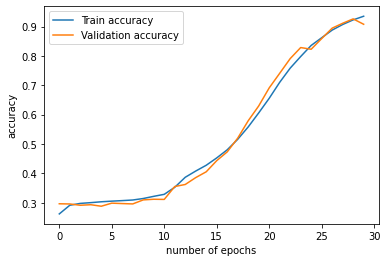

In [181]:
# Insert your code here to plot Epochs Vs. training and validation accuracy (2 points)
plt.plot(epochs_list, training_acc)
plt.plot(epochs_list, validation_acc)
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend(["Train accuracy", "Validation accuracy"])


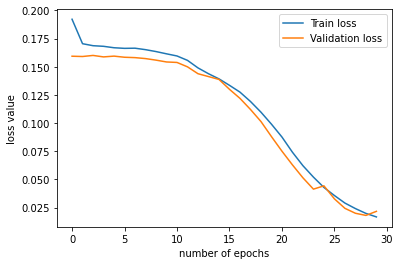

In [182]:
# Insert your code here to plot Epochs Vs. training and validation loss (2 points)
plt.plot(epochs_list, training_loss)
plt.plot(epochs_list, validation_loss)
plt.xlabel("number of epochs")
plt.ylabel("loss value")
plt.legend(["Train loss", "Validation loss"])

## Steps for Word recognition:

First, prepare a list having all the words from test set mapped to their corresponding vectors (lexicon for both Omega and Alpha representations).

---

**1 point**

---


In [183]:
alpha_label_vector=[]
omega_label_vector=[]
alpha_true_label=[]
omega_true_label=[]
for words in test_df['Label']:
    alpha_true_label.append(words)
    omega_true_label.append(words)
    alpha_label_vector.append(get_Alpha_vector(words))
    omega_label_vector.append(get_Omega_vector(words))


For every image in the test set:
1. Predict the output vector representation from the trained model(s) when the image is given as input.
2. Find the word class(from lexicon) for which the similarity of its vector representation will be highest with the output vector.
3. If predicted word = true word, then it is a correct prediction, otherwise incorrect prediction.

---

Let us now perform recognition using trained Alph amodel on the test set. 

First, load the test images and their vector representations.

---

**1 point**

---

In [184]:
# Insert code to load test images and its vector labels (1 points)
# print(test_df)
test_image_alpha=make_x_a(test_df, test_dir_path)
test_label_alpha=make_y_a(test_df)

Now load the saved trained Alpha model from the file and predict the labels

---

**1+3 points**

---

In [185]:
# Insert code for loading the saved model from file 
alpha_model=tf.keras.models.load_model('/home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/alpha')

In [186]:
# Insert code for predicting word labels of the test set images 
def cosine_sim(a, b):
    a=np.array(a)
    b=np.array(b)
    sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return sim
#print(cosine_sim([1, 2, 3], [1, 2, 3]))
alpha_predicted_label=[]
alpha_predicted_vector=alpha_model.predict(x=test_image_alpha)
for vector in alpha_predicted_vector:
    alpha_sim=[]
    for a in alpha_label_vector:
        alpha_sim.append(cosine_sim(vector, a))
    #alpha_predicted_label.append(alpha_sim[alpha_sim.index(max(alpha_sim))])
    alpha_predicted_label.append(alpha_true_label[alpha_sim.index(max(alpha_sim))])


In [187]:
print((alpha_predicted_label))

['help', 'as', 'message', 'section', 'address', 'd', 'section', 'south', 'like', 'real', 'at', 'what', 'more', 'terms', 'page', 'file', 'sign', 'over', 'show', 'page', 'while', 'sign', 'day', 'order', 'rights', 'more', 'terms', 'product', 'internet', 'these', 'send', 'own', 'send', 'days', 'internet', 'these', 'special', 'next', 'part', 'south', 's', 'management', 'total', 'many', 'b', 'than', 'version', 'total', 'that', 'management', 'did', 'price', 'made', 'good', 'price', 'results', 'forum', 'comments', 'd', 'terms', 'good', 'high', 'data', 'price', 'will', 'f', 'county', 'full', 'school', 'line', 'january', 'these', 'because', 'reviews', 'o', 'under', 'news', 'here', 'development', 'report', 'security', 'for', 'here', 'because', 'both', 'open', 'd', 'phone', 'b', 'sign', 'link', 'details', 'o', 'file', 'details', 'sign', 'b', 'many', 'total', 'management', 'been', 'business', 'member', 'comments', 'games', 'total', 'go', 'using', 'need', 'after', 'internet', 'these', 'are', 'and', 

Let us evaluate the performance of the model. The effective accuracy of model is defined as harmonic mean(HM) of accuracy with seen class images and accuracy with unseen class images.

---

**2 Points**

---

In [188]:
# Insert code to compute accuracy of images that belong to seen classes 
def accuracy(a, b):
    return sum(1 for x,y in zip(a,b) if x == y) / float(len(a))
    
seen_predicted=[]
seen_true=[]
for i in test_df.index:
    w=test_df['Label'][i]
    if w in seen_words:
        seen_predicted.append(alpha_predicted_label[i])
        seen_true.append(alpha_true_label[i])

seen_accuracy=accuracy(seen_predicted, seen_true)
print("Accuracy of seen classes : "+str(100*seen_accuracy)+"%")

# Insert code to compute accuracy of images that belong to unseen classes
unseen_predicted=[]
unseen_true=[]
for i in test_df.index:
    w=test_df['Label'][i]
    if w in unseen_words:
        unseen_predicted.append(alpha_predicted_label[i])
        unseen_true.append(alpha_true_label[i])

unseen_accuracy=accuracy(unseen_predicted, unseen_true)
print("Accuracy of unseen classes : "+str(100*unseen_accuracy)+"%")


# Insert code to compute effective accuracy
e_acc=2*seen_accuracy*unseen_accuracy
e_acc/=(seen_accuracy+unseen_accuracy)
print("Effective accuracy of alpha model : "+str(100*e_acc)+"%")


Accuracy of seen classes : 95.0%
Accuracy of unseen classes : 11.25%
Effective accuracy of alpha model : 20.11764705882353%


Let us now perform recognition using trained Alpha model on the test set.
 
First, load the test images and their Omega vector representations.

---

**1 Points**

---

In [189]:
# Insert code to load test images and its vector labels
test_image_omega=make_x(test_df, test_dir_path)
test_label_omega=make_y(test_df)


Now load the saved trained Omega model from the file and predict the labels

---

**1+3 Points**

---

In [190]:
# Insert code for loading the saved model from file
omega_model=tf.keras.models.load_model('/home/anshul/Downloads/Lab3a/WR-Dataset/checkpoint/omega')


In [191]:
# Insert code for predicting word labels of the test set images
omega_predicted_label=[]
omega_predicted_vector=omega_model.predict(x=test_image_omega)
for vector in omega_predicted_vector:
    omega_sim=[]
    for a in omega_label_vector:
        omega_sim.append(cosine_sim(vector, a))
        #print(len(vector), " ", len(a))
    #alpha_predicted_label.append(alpha_sim[alpha_sim.index(max(alpha_sim))])
    omega_predicted_label.append(omega_true_label[omega_sim.index(max(omega_sim))])



In [192]:
print(omega_predicted_label)

['help', 'as', 'message', 'management', 'address', 'available', 'education', 'available', 'like', 'send', 'at', 'what', 'care', 'states', 'game', 'while', 'find', 'between', 'product', 'game', 'while', 'using', 'day', 'between', 'photo', 'care', 'computer', 'product', 'university', 'three', 'and', 'own', 'and', 'days', 'network', 'these', 'special', 'internet', 'part', 'south', 's', 'computer', 'real', 'any', 'b', 'than', 'version', 'real', 'that', 'computer', 'did', 'place', 'made', 'own', 'place', 'results', 'forum', 'comments', 'own', 'terms', 'good', 'find', 'data', 'price', 'will', 'f', 'january', 'full', 'school', 'line', 'january', 'these', 'member', 'reviews', 'o', 'under', 'news', 'here', 'development', 'report', 'security', 'for', 'here', 'members', 'both', 'open', 'd', 'product', 'h', 'him', 'link', 'details', 'him', 'file', 'details', 'sign', 'h', 'any', 'real', 'computer', 'been', 'business', 'number', 'comments', 'games', 'real', 'go', 'using', 'send', 'after', 'universit

Evaluate the performance of the Omega model

---

**2 Points**

---

In [193]:
seen_predicted=[]
seen_true=[]
for i in test_df.index:
    w=test_df['Label'][i]
    if w in seen_words:
        seen_predicted.append(omega_predicted_label[i])
        seen_true.append(omega_true_label[i])

seen_accuracy=accuracy(seen_predicted, seen_true)
print("Accuracy of seen classes : "+str(100*seen_accuracy)+"%")

# Insert code to compute accuracy of images that belong to unseen classes
unseen_predicted=[]
unseen_true=[]
for i in test_df.index:
    w=test_df['Label'][i]
    if w in unseen_words:
        unseen_predicted.append(omega_predicted_label[i])
        unseen_true.append(omega_true_label[i])

unseen_accuracy=accuracy(unseen_predicted, unseen_true)
print("Accuracy of unseen classes : "+str(100*unseen_accuracy)+"%")


# Insert code to compute effective accuracy
e_acc=2*seen_accuracy*unseen_accuracy
e_acc/=(seen_accuracy+unseen_accuracy)
print("Effective accuracy of alpha model : "+str(100*e_acc)+"%")




Accuracy of seen classes : 93.75%
Accuracy of unseen classes : 44.375%
Effective accuracy of alpha model : 60.23755656108597%


# Results
Based on your experimental outcome and your observations, which representation is better, according to you? 

---

**2 Points**

---

The Omega model is much better as the accuracy on the unseen classes is very high as compared to the Alpha model on the unseen classes. This means that the Omega model will perform better in real life situations where our model will have to predict on data which it might not have seen till now. Also the effective accuracy of the Omega model is almost double that of the Alpha model.

We have used only words from the test set to find the matching word. How could results be affected if the lexicon had both: train and test words?

---

**2 Points**

---

In that case the testing accuracy might have decreased because the model could have predicted the output label from one of the train labels. This would further decrease the unseen classes accuracy. This happens because now our model may be predicting the output label not in the unseen classes. Although the seen classes accuracy might increase a little bit because of this, but as that accuracy is already around 100% therefore in the effective accuracy it wouldn't cause a significant change. So the overall effective accuracy would decrease if we include the train words also in the lexicon.